In [60]:
import pandas as pd
import numpy as np
import video.df as df
from video import vid
from video import df
from video import frame
from video import preprocess as pr

import video.reader as r
import cv2 as cv
from video.reader import VideoReader


from typing import List, Union
from numpy.typing import ArrayLike

import matplotlib.pyplot as plt
from importlib import reload

### check the potential hazard with zero-crossing algorithm

In [3]:
# get the lightness difference
v = pr.get_lightness_difference('videos/Banned Pokemon Seizure Scene.mp4')

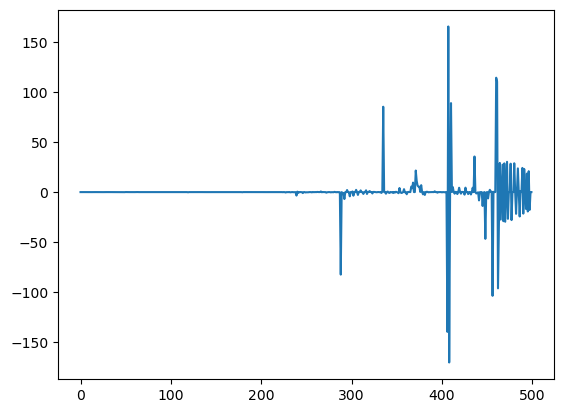

In [262]:
plt.plot(v[:500])

In [6]:
v[:10]

array([ 0.0032,  0.0252,  0.024 ,  0.0388,  0.0064,  0.01  , -0.0044,
       -0.0076, -0.0064,  0.0044])

In [19]:
v1 = pr.get_lightness_difference1('videos/Banned Pokemon Seizure Scene.mp4')

In [ ]:
v1[:10]

array([-0.0032, -0.0252, -0.024 , -0.0388, -0.0064, -0.01  ,  0.0044,
        0.0076,  0.0064, -0.0044])

In [35]:
len(v), len(v1) # v1 is the same as v but opposite signs

(784, 784)

In [ ]:
np.sign(v)[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.])

In [37]:
len(np.diff(np.sign(v))) # one less than original

783

In [40]:
# if the next sign is the same the difference is going to be 0, els 2 or - 2
np.diff(np.sign(v))[:10]

array([ 0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  2.,  0.])

In [47]:
# get just indexes where the diff is 2 or -2
np.where(np.diff(np.sign(v)))[0][:10] + 1

array([ 6,  9, 12, 13, 24, 26, 30, 31, 36, 38])

In [45]:
v[:10]

array([ 0.0032,  0.0252,  0.024 ,  0.0388,  0.0064,  0.01  , -0.0044,
       -0.0076, -0.0064,  0.0044])

In [267]:
v[np.absolute(v) > 5]

array([ -82.4752,   -6.9328,   85.3468,    5.4956,    9.4776,   21.552 ,
         11.4316,    6.4332,    5.4956,    5.4452,    6.9168, -139.7496,
        165.5932, -170.3384,   88.9688,    5.0244,   35.5952,   -8.2852,
        -13.8584,  -46.7288,   -6.2968, -103.6952,  114.3596,  110.4164,
        -96.2004,  -36.5948,   29.1684,  -27.4368,   27.4084,  -29.082 ,
         28.734 ,  -29.6352,   30.2756,  -26.7288,   28.398 ,  -27.9672,
         28.82  ,  -21.7056,   23.7004,  -24.358 ,   24.1736,  -21.5116,
         23.1336,  -16.7964,   18.4952,  -19.3624,   20.8996,  -17.826 ,
         19.3088,  -17.304 ,   18.998 ,  -16.2764,   18.7636,  -18.4   ,
         19.8524,  -14.5292,   16.4592,  -14.0624,   15.0488,  -16.2676,
         16.3216,  -13.7644,   13.4732,  -13.2052,   14.4104,  -14.522 ,
         14.3112,  -16.222 ,   15.8336,  -14.0136,   14.2532,  -15.01  ,
         15.6192,  -14.716 ,   14.9232,  -14.9428,   14.242 ,  -12.2712,
         12.706 ,  -15.8044,   15.8936,  -16.5528, 

In [271]:
def find_zero_crossings(lightness_difference: np.array, treshold:int = 50):
    ''' 
    returns indexes of lightness difference array 
    where the element changes the sign
    '''
    lightness_difference = np.where(np.absolute(lightness_difference) > treshold, 
                                    0, lightness_difference)
    return np.where(np.diff(np.sign(lightness_difference)))[0] + 1

In [289]:
#np.where(np.absolute(v) > 5, np.nan, v)

In [276]:
np.where(np.absolute(v) > 50, 0, v)[:5]

array([0.0032, 0.0252, 0.024 , 0.0388, 0.0064])

In [272]:
find_zero_crossings(v).shape

(431,)

In [48]:
zero_crossings = np.where(np.diff(np.sign(v)))[0] + 1

In [49]:
zero_crossings[:10]

array([ 6,  9, 12, 13, 24, 26, 30, 31, 36, 38])

In [50]:
zero_crossings1 = np.where(np.diff(np.sign(v1)))[0] + 1 # +1 to retrun the original index

In [55]:
zero_crossings.shape[0]

422

In [53]:
# just double confirm that no matter the sign we get same result and 
# I can use simplier differencing
(zero_crossings1 == zero_crossings).sum()

422

In [56]:
(zero_crossings1 == zero_crossings).sum() == zero_crossings.shape[0]

True

Now we need to check if the lightness difference crosses 0 more than 3 times per second.

In [57]:
# we have 30 frames per second video
# if there is more than 3 consecutive zero crossings in 30 frames window
# it is a potential hazard
fps = 30

In [81]:
zero_crossings[:-1]

array([  6,   9,  12,  13,  24,  26,  30,  31,  36,  38,  39,  40,  41,
        43,  45,  46,  48,  50,  52,  53,  54,  56,  57,  58,  59,  61,
        64,  66,  68,  69,  70,  71,  72,  74,  75,  76,  79,  80,  82,
        83,  86,  87,  88,  89,  92,  94,  95,  96,  97,  98,  99, 101,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116,
       118, 119, 120, 127, 128, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 143, 145, 147, 148, 151, 152, 153, 156, 157, 158,
       159, 160, 162, 163, 164, 167, 168, 169, 170, 171, 172, 173, 175,
       178, 180, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196,
       197, 198, 200, 201, 203, 206, 207, 208, 209, 210, 211, 212, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 231, 232, 234,
       236, 240, 241, 243, 244, 248, 249, 254, 256, 257, 258, 259, 261,
       262, 267, 268, 270, 271, 272, 275, 276, 281, 283, 284, 285, 286,
       287, 295, 296, 299, 300, 301, 302, 305, 306, 308, 312, 31

In [83]:
zero_crossings[-1]

783

In [125]:
def extract_windows(arr: np.array, 
                    start: int, end: int, sub_window_size: int):
    '''
    Creates sliding windows of sub_window_size 
    '''
    
    end = end - sub_window_size + 1
    sub_windows = (
        start +
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(end - start), 0).T
    )
    
    # one line function if there is no need for start / end indexes
    # return np.lib.stride_tricks.sliding_window_view(arr, window_shape=sub_window_size)
    return arr[sub_windows]

test `extract_windows` function

In [126]:
extract_windows(zero_crossings, 20, len(zero_crossings), 30)

array([[ 54,  56,  57, ...,  96,  97,  98],
       [ 56,  57,  58, ...,  97,  98,  99],
       [ 57,  58,  59, ...,  98,  99, 101],
       ...,
       [725, 726, 727, ..., 777, 779, 780],
       [726, 727, 730, ..., 779, 780, 781],
       [727, 730, 732, ..., 780, 781, 783]])

In [127]:
zero_crossings[20]

54

In [76]:
X = np.arange(30)

In [98]:
X

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [108]:
extract_windows(X, 3, len(X), 5)

array([[ 0,  1,  2,  3,  4],
       [ 1,  2,  3,  4,  5],
       [ 2,  3,  4,  5,  6],
       [ 3,  4,  5,  6,  7],
       [ 4,  5,  6,  7,  8],
       [ 5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 12],
       [ 9, 10, 11, 12, 13],
       [10, 11, 12, 13, 14],
       [11, 12, 13, 14, 15],
       [12, 13, 14, 15, 16],
       [13, 14, 15, 16, 17],
       [14, 15, 16, 17, 18],
       [15, 16, 17, 18, 19],
       [16, 17, 18, 19, 20],
       [17, 18, 19, 20, 21],
       [18, 19, 20, 21, 22],
       [19, 20, 21, 22, 23],
       [20, 21, 22, 23, 24],
       [21, 22, 23, 24, 25],
       [22, 23, 24, 25, 26],
       [23, 24, 25, 26, 27],
       [24, 25, 26, 27, 28],
       [25, 26, 27, 28, 29]])

In [115]:
sw = 0 + np.expand_dims(np.arange(5), 0) + np.expand_dims(np.arange(len(X) - 5 +1), 0).T

In [124]:
np.expand_dims(np.arange(5), 0) + np.expand_dims(np.arange(len(X) - 5 +1), 0).T

array([[ 3,  4,  5,  6,  7],
       [ 4,  5,  6,  7,  8],
       [ 5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 12],
       [ 9, 10, 11, 12, 13],
       [10, 11, 12, 13, 14],
       [11, 12, 13, 14, 15],
       [12, 13, 14, 15, 16],
       [13, 14, 15, 16, 17],
       [14, 15, 16, 17, 18],
       [15, 16, 17, 18, 19],
       [16, 17, 18, 19, 20],
       [17, 18, 19, 20, 21],
       [18, 19, 20, 21, 22],
       [19, 20, 21, 22, 23],
       [20, 21, 22, 23, 24],
       [21, 22, 23, 24, 25],
       [22, 23, 24, 25, 26],
       [23, 24, 25, 26, 27],
       [24, 25, 26, 27, 28],
       [25, 26, 27, 28, 29],
       [26, 27, 28, 29, 30],
       [27, 28, 29, 30, 31],
       [28, 29, 30, 31, 32]])

In [185]:
sw = extract_windows(zero_crossings, 0, len(zero_crossings), fps)

In [186]:
sw

array([[  6,   9,  12, ...,  66,  68,  69],
       [  9,  12,  13, ...,  68,  69,  70],
       [ 12,  13,  24, ...,  69,  70,  71],
       ...,
       [725, 726, 727, ..., 777, 779, 780],
       [726, 727, 730, ..., 779, 780, 781],
       [727, 730, 732, ..., 780, 781, 783]])

In [130]:
len(sw)

393

In [171]:
sw.shape

(393, 30)

In [217]:
np.array([1, 2]) + np.array([3, 4])

array([4, 6])

In [227]:
inds = np.array([], dtype='int')
for s in sw:
    # for every slide in sliding windows of size FPS
    # create sliding windows of size 3
    windows = np.lib.stride_tricks.sliding_window_view(s, \
                                window_shape=3)
    #print(windows.shape)
    # check which windows have 3 consectutive numbers 
    cond = np.all(np.diff(windows, axis=1) == 1, axis = 1)
    #print(cond.shape)
    # return list of seconds in video that are hazard
    inds = np.append(inds, windows[cond][:, 0])
print(inds)

[ 38  39  52 ... 756 757 779]


In [234]:
np.unique(inds)

array([ 38,  39,  52,  56,  57,  68,  69,  70,  74,  86,  87,  94,  95,
        96,  97, 103, 104, 105, 106, 107, 108, 109, 110, 111, 118, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 151, 156, 157, 158, 162,
       167, 168, 169, 170, 171, 184, 185, 186, 187, 188, 189, 194, 195,
       196, 206, 207, 208, 209, 210, 215, 216, 217, 218, 219, 220, 221,
       256, 257, 270, 283, 284, 285, 299, 300, 331, 332, 343, 344, 345,
       346, 347, 359, 360, 379, 380, 391, 392, 393, 394, 400, 407, 450,
       464, 468, 469, 493, 494, 495, 496, 501, 502, 510, 519, 520, 521,
       522, 526, 527, 547, 548, 549, 550, 551, 555, 556, 562, 566, 570,
       571, 575, 576, 577, 581, 582, 650, 651, 655, 656, 657, 665, 676,
       694, 695, 712, 725, 742, 743, 755, 756, 757, 779])

In [193]:
sw.shape, np.array(cond).shape

((393, 30), (393, 28))

In [235]:
def find_hazard_crossings(sliding_windows: np.array, consecutive_numbers=3, fps=30):
    '''
    Find if there are (3) consecutive numbers of frames in zero_crossing array.
    Parameters:
    sliding_windows: 2D numpy array of sliding windows of FPS (frames per second) size
    consecutive_numbers: how many consecutive numbers we have to check. 
    Default is 3. 3 consecutive flashes per second are dangerous
    Returns:
    list of indexes that start flashes
    '''
    frame_numbers = np.array([], dtype='int')
    for sw in sliding_windows:
        # for every slide in sliding windows of size FPS
        # create sliding windows of size 3
        windows = np.lib.stride_tricks.sliding_window_view(sw, \
                                    window_shape=consecutive_numbers)
        # check which windows have 3 consectutive numbers 
        cond = np.all(np.diff(windows, axis=1) == 1, axis = 1)
        frame_numbers = np.append(frame_numbers, windows[cond][:, 0])
        # return list of seconds in video that are hazard
    return np.unique(frame_numbers)

In [ ]:
def frames_to_seconds(frame_numbers: np.array):
    ''' 
    takes a frame numbers
    returns a list of seconds in the video where the content can cause a seizure
    '''
    return list(set(frame_numbers / 30))


In [258]:
find_hazard_crossings(sw)

array([ 38,  39,  52,  56,  57,  68,  69,  70,  74,  86,  87,  94,  95,
        96,  97, 103, 104, 105, 106, 107, 108, 109, 110, 111, 118, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 151, 156, 157, 158, 162,
       167, 168, 169, 170, 171, 184, 185, 186, 187, 188, 189, 194, 195,
       196, 206, 207, 208, 209, 210, 215, 216, 217, 218, 219, 220, 221,
       256, 257, 270, 283, 284, 285, 299, 300, 331, 332, 343, 344, 345,
       346, 347, 359, 360, 379, 380, 391, 392, 393, 394, 400, 407, 450,
       464, 468, 469, 493, 494, 495, 496, 501, 502, 510, 519, 520, 521,
       522, 526, 527, 547, 548, 549, 550, 551, 555, 556, 562, 566, 570,
       571, 575, 576, 577, 581, 582, 650, 651, 655, 656, 657, 665, 676,
       694, 695, 712, 725, 742, 743, 755, 756, 757, 779])

In [257]:
(find_hazard_crossings(sw) / 30).astype(int)

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  9,
        9,  9,  9,  9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19,
       19, 19, 19, 19, 21, 21, 21, 21, 21, 22, 22, 23, 23, 23, 24, 24, 24,
       25, 25, 25, 25])

In [198]:
test_arr = [1, 3, 4, 5, 8, 9, 20, 21, 22]

In [199]:
windows = np.lib.stride_tricks.sliding_window_view(test_arr, window_shape=3)

In [200]:
windows

array([[ 1,  3,  4],
       [ 3,  4,  5],
       [ 4,  5,  8],
       [ 5,  8,  9],
       [ 8,  9, 20],
       [ 9, 20, 21],
       [20, 21, 22]])

In [201]:
np.diff(windows, axis=1)

array([[ 2,  1],
       [ 1,  1],
       [ 1,  3],
       [ 3,  1],
       [ 1, 11],
       [11,  1],
       [ 1,  1]])

In [202]:
np.diff(windows, axis=1) == 1

array([[False,  True],
       [ True,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True,  True]])

In [203]:
# axis = 0 returns [False, False]
np.all(np.diff(windows, axis=1) == 1, axis = 0)

array([False, False])

In [161]:
a = np.all(np.diff(windows, axis=1) == 1, axis = 1)

In [162]:
a 

array([False,  True, False, False, False, False,  True])

In [163]:
windows[a]

array([[ 3,  4,  5],
       [20, 21, 22]])

In [170]:
# get the numbers that starts 3 consecutive numbers
windows[a][:, 0]

array([ 3, 20])

In [175]:
(windows[a][:, 0] /3).astype(int)

array([1, 6])

In [243]:
rs, fps = VideoReader.get_vid('videos/Red Spin.mp4', conversion=0)

In [245]:
rs.shape

(300, 50, 50, 3)

In [247]:
frames = rs.shape[0]
height = rs.shape[1]
width = rs.shape[2]

In [248]:
frames, height, width

(300, 50, 50)

In [251]:
rs.reshape(-1, 3).shape

(750000, 3)

In [254]:
red = rs.reshape(-1, 3)[:, 2] # extract red channell from BGR